In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/rapido-assingment/ct_rr.csv
/kaggle/input/holiday-list/Holiday list - Sheet1.csv


****Problem Statement** :** To Predict the ride requests for the future based on the previous years data

****Business Problem** :** To allocate the resources(Vehicles) efficiently to maximize the resource utilization and minimize the coustomer wait time

****Approach** :**
* Aggregated the ride requests at a hour level, day level and week level. 
* Used Day Level aggregated data for two reasons. Primarily,it would be difficult to predict at an hourly level as one ride's pick up location could be another ride's drop locaion. Thereby bloating the no.of resources required. Secondly, seasonality of the data is better captured at a day level data.
* Perfomred ETS to set a base expectation
* After noticing that a few peaks coincide with the public holidays, long-weekends, created a variable "Weightage", which has three clasess "0,1,2" depending on the significance of the holiday
* Built a SARIMAX model with the exogenous variable to forecast the ride requests
* Realizing that for a effective resource allocation a granular level forecast is required, culstered the data and performed prediction on individual clusters

****Future Tasks** :**
* Better tweaking the holiday calender and adding more Causal variables like  daily Promotional data, PR campaign data could help in improving prediction
* Prediction at an hourly level could possibly be attempted by using Ride minutes

## 1.0 Load and read the data

In [2]:
train_data = pd.read_csv("/kaggle/input/rapido-assingment/ct_rr.csv")
holiday_data = pd.read_csv("/kaggle/input/holiday-list/Holiday list - Sheet1.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train_data.head())
print(holiday_data.head(2))
print(train_data.shape)
print(train_data.isna().sum())
print(train_data.dtypes)

                    ts number   pick_lat   pick_lng   drop_lat   drop_lng
0  2018-04-07 07:07:17  14626  12.313621  76.658195  12.287301  76.602280
1  2018-04-07 07:32:27  85490  12.943947  77.560745  12.954014  77.543770
2  2018-04-07 07:36:44  05408  12.899603  77.587300  12.934780  77.569950
3  2018-04-07 07:38:00  58940  12.918229  77.607544  12.968971  77.636375
4  2018-04-07 07:39:29  05408  12.899490  77.587270  12.934780  77.569950
         Day           Holiday  Weightage        Date
0   Saturday        Idu'l Fitr        1.0  2018-06-16
1  Wednesday  Independence Day        2.0  2018-08-15
(8381556, 6)
ts          0
number      0
pick_lat    0
pick_lng    0
drop_lat    0
drop_lng    0
dtype: int64
ts           object
number       object
pick_lat    float64
pick_lng    float64
drop_lat    float64
drop_lng    float64
dtype: object


There are around 8.3 million ride requests in the given data

In [4]:
#Converting to date time format
train_data['ts'] = pd.to_datetime(train_data['ts'])
holiday_data['Date'] = pd.to_datetime(holiday_data['Date'])

## 2.0 Exploratory Data Analysis
This section deals with gathering insights from the data.

Following Hypothesis could be generated from the nature of the domain the data belongs to, before actullay exploring the data

1. There will be an increase in the traffic as the months pass by.
    
    Explanation - Population adoption has a general upward trend with time during the intial stages of
    the launch, so I can expect more customers on boarding rapido. Also, generally companies expand
    their businesses over time leading to more customers using the service.
    

2. Traffic on weekdays will be more as compared to weekends/holidays.
    
    Explanation - Office goers/ College goers use the service to commute to there respective destination
    on weekdays 
    
    
3. Traffic during the peak hours will be high.
    
    Explanation - In continuation to point 2, most of the office/college in/out times are at specific  times of the day 
    
We will try to validate each of these hypothesis based on the dataset. Now let’s have a look at the dataset.

In [5]:
import squarify
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Creating a new column with all 1's, this will help in aggregating the data
train_data['ride'] = 1

In [7]:
train_data.set_index('ts')
print(train_data['ts'].max())
print(train_data['ts'].min())

2019-04-07 23:59:59
2018-04-07 01:23:31


There is around 1 year of data to analyse

### 2.1 Plotting day level aggregated data

In [8]:
train_day = pd.DataFrame(train_data.groupby(pd.Grouper(key='ts', freq='1D')).ride.sum()).to_records()
train_day = pd.DataFrame(train_day)
train_day.columns = ['time_stamp','ride_day']
train_day.head(2)

,time_stamp,ride_day
0,2018-04-07,9375
1,2018-04-08,5716


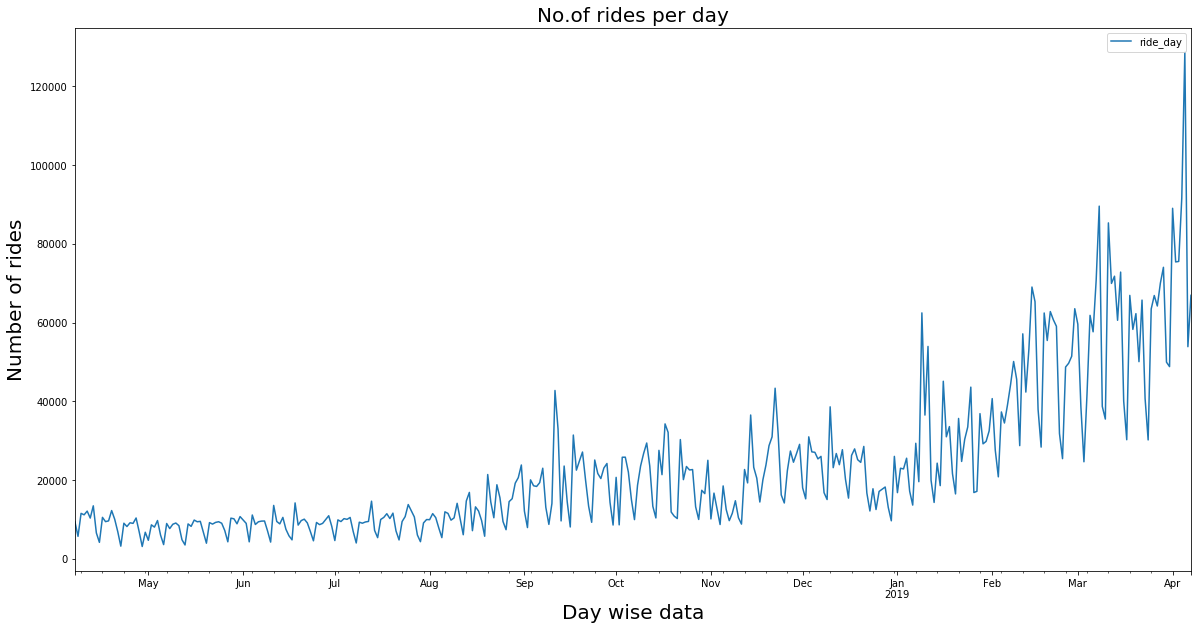

In [9]:
train_day.plot(x='time_stamp',y='ride_day',figsize=(20,10))
plt.title('No.of rides per day',fontsize=20)
plt.ylabel('Number of rides', fontsize=20)
plt.xlabel('Day wise data', fontsize=20)
plt.show()

In [10]:
train_day.tail(3)

,time_stamp,ride_day
363,2019-04-05,128665
364,2019-04-06,53892
365,2019-04-07,66932


**Insights**
1. On April 5th 2019, there is sudden spike in the requests. There could be a public holiday or a promotiona associated with it. These spikes are conistent at varying magnitude across the data
2. The data seems to be having a weekly seasonal nature
3. The trend and level of the data seems to be Multiplicative
4. On the first look the data looks like non-stationary
5. As hypothesised, the number of ride requests increased at the months passed by


### 2.2 Plotting WEEK level aggregated data

In [11]:
train_week = pd.DataFrame(train_data.groupby(pd.Grouper(key='ts', freq='1W')).ride.sum()).to_records()
train_week = pd.DataFrame(train_week)
train_week.columns = ['time_stamp','ride_week']
train_week.head(2)

,time_stamp,ride_week
0,2018-04-08,15091
1,2018-04-15,69476


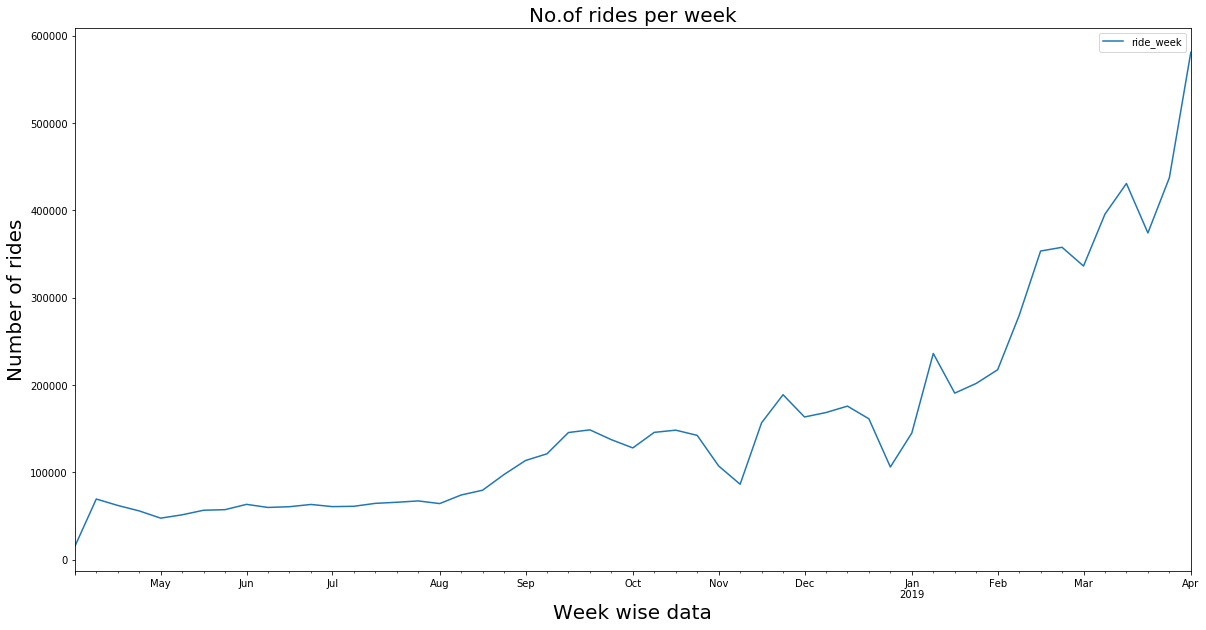

In [12]:
train_week.plot(x='time_stamp',y='ride_week',figsize=(20,10))
plt.title('No.of rides per week',fontsize=20)
plt.ylabel('Number of rides', fontsize=20)
plt.xlabel('Week wise data', fontsize=20)
plt.show()

### 2.2 Plotting Hour level aggregated data

In [13]:
train_hour = pd.DataFrame(train_data.groupby(pd.Grouper(key='ts', freq='1H')).ride.sum()).to_records()
train_hour = pd.DataFrame(train_hour)
train_hour.columns = ['time_stamp','ride_hour']
train_hour.head(2)

,time_stamp,ride_hour
0,2018-04-07 01:00:00,20
1,2018-04-07 02:00:00,5


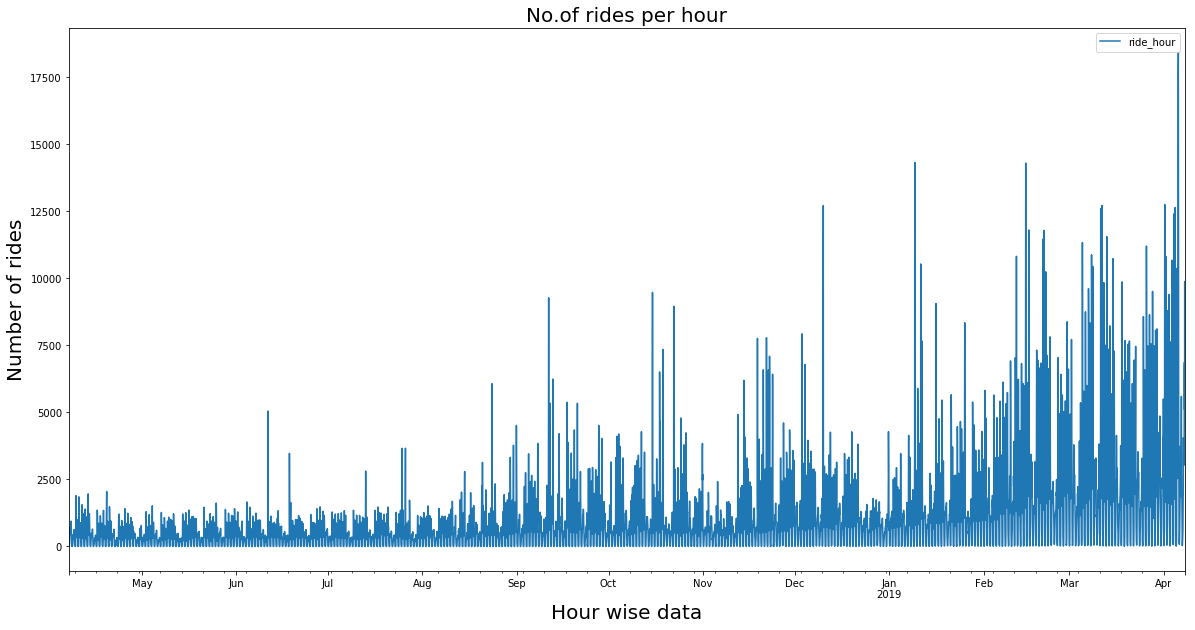

In [14]:
train_hour.plot(x='time_stamp',y='ride_hour',figsize=(20,10))
plt.title('No.of rides per hour',fontsize=20)
plt.ylabel('Number of rides', fontsize=20)
plt.xlabel('Hour wise data', fontsize=20)
plt.show()

### 2.3 Data aggregated at day level

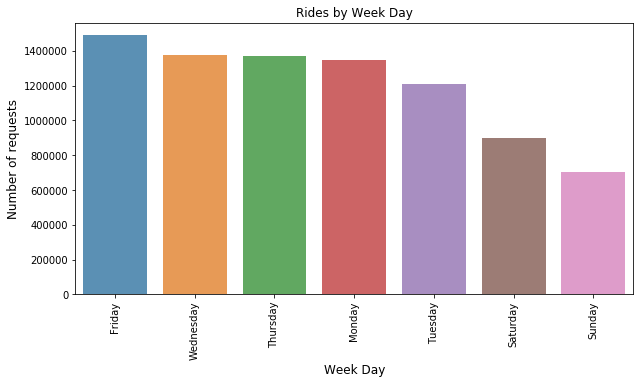

In [15]:
train_data['ride_weekday'] = train_data['ts'].dt.weekday_name

count_  = train_data['ride_weekday'].value_counts()
count_ = count_[:12,]
plt.figure(figsize=(10,5))
sns.barplot(count_.index, count_.values, alpha=0.8)
plt.title('Rides by Week Day')
plt.xticks(rotation='vertical')
plt.ylabel('Number of requests', fontsize=12)
plt.xlabel('Week Day', fontsize=12)
plt.show()

As hypothesised, Weekdays have significantly more rides than weekend

### 2.3 Data aggregated at Hour level

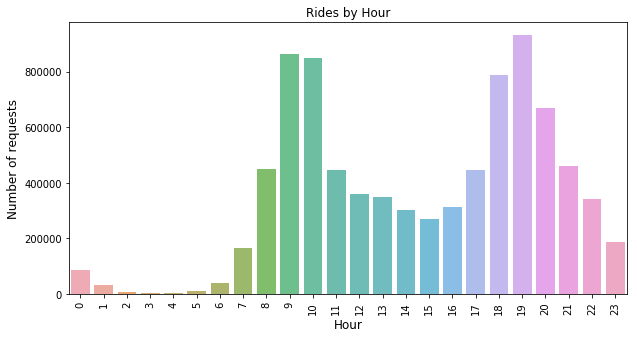

In [16]:
train_data['ride_hour'] = train_data['ts'].dt.hour

count_  = train_data['ride_hour'].value_counts()
count_ = count_[:24,]
plt.figure(figsize=(10,5))
sns.barplot(count_.index, count_.values, alpha=0.8)
plt.title('Rides by Hour')
plt.xticks(rotation='vertical')
plt.ylabel('Number of requests', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.show()

As expected, most of the requests are dueing the peak hours. i.e 8am to 11am  followed by 5pm to 9pm

## 3.0 Model Building and Forecast

The model is built on data aggregated at a day level for the following reasons
* One ride's pick up location could be another ride's drop location. There by if predicted at an hourly level, without including the ride time, it might lead to bloated prediction of requests
* Hour level data is sparse and erratic

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import math
from scipy.stats import normaltest
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
%matplotlib inline

### 3.1 Error Trend and Sesonlaity
ETS methods are basic and give a very good understanding of the data and it would serve as a base model RMSE, further models need to perform better than this


In [18]:
## Train test split
size = int(len(train_day) * 0.85)
train_day_final, test_day_final = train_day[0:size], train_day[size:len(train_day)]

In [19]:
train_day.shape

(366, 2)

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train_day_final['ride_day']), seasonal='mul',trend='mul', seasonal_periods=7).fit()
pred_test = pd.DataFrame(model.predict(start=test_day_final.index[0], end=test_day_final.index[-1]))
pred_train = pd.DataFrame(model.predict(start=train_day_final.index[0], end=train_day_final.index[-1]))


In [21]:
pred_test.index=test_day_final.index


In [22]:
rmse_train_ETS = math.sqrt(mean_squared_error(train_day_final["ride_day"],pred_train ))
rmse_test_ETS = math.sqrt(mean_squared_error(test_day_final["ride_day"],pred_test ))
print("RMSE for the train data is ", rmse_train_ETS)
print("RMSE for the test data is ", rmse_test_ETS)

RMSE for the train data is  4806.160589493829
RMSE for the test data is  11318.876364684156


### RMSE
**RMSE tells us how much our prediction is off. For example for the above model, test RMSE is 11000, it means that the predicted value might be off from the actual value by 11000 requests per day.**

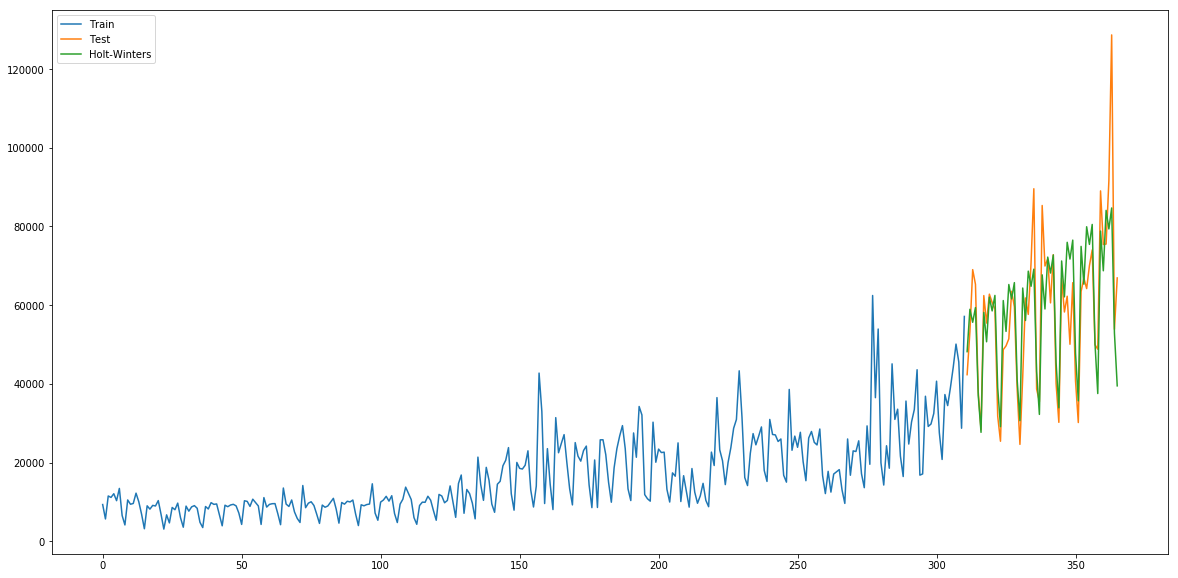

In [23]:
plt.figure(figsize=(20,10))
plt.plot(train_day_final.index, train_day_final['ride_day'], label='Train')
plt.plot(test_day_final.index, test_day_final['ride_day'], label='Test')
plt.plot(pred_test.index, pred_test, label='Holt-Winters')
plt.legend(loc='best')

### 3.2 Building SARIMAX model
* The data clearly has a weekly seasonality and I would like to add holiday, promotional calender as exogenous variables, hence, I chose SARIMAX
* The first step towards building a SARIMAX model is to check if the data is stationary. Dickey-Fuller Test is used to check for stationarity.

### 3.2.1 SARIMAX without Exogenous variables

In [24]:
#Defining a function that tests for stationarity and plots ACF and PACF plots
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))

    y.plot(ax=ax1, figsize=figsize)
    
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
   

    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   2.1729
p-value                          0.9989
Lags Used                       17.0000
Number of Observations Used    348.0000
Critical Value (1%)             -3.4493
Critical Value (5%)             -2.8699
Critical Value (10%)            -2.5712
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


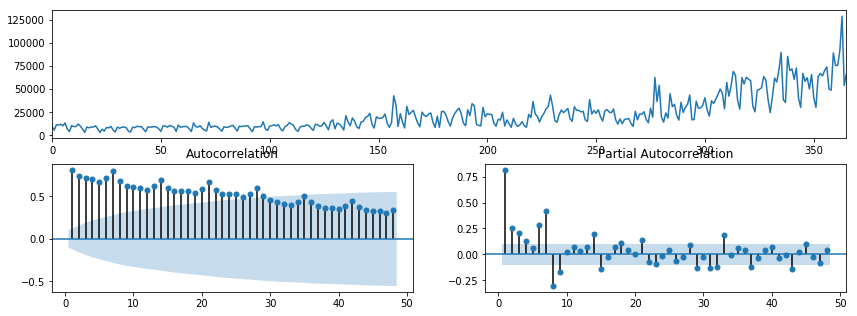

In [25]:
check_stationarity(train_day['ride_day'])

1. From the ACF plot it's clear that there is a positve seasonal trend repeating ever 7 ticks, which is every week
2. The data isn't stationary

In [26]:
#Performing a sesonal difference in an attempt to make the data stationary
train_day['ride_day'] = train_day['ride_day'] - train_day['ride_day'].shift(7)


In [27]:
train_day.head(3)

,time_stamp,ride_day
0,2018-04-07,NaN
1,2018-04-08,NaN
2,2018-04-09,NaN


Results of Dickey-Fuller Test:
Test Statistic                  -7.3776
p-value                          0.0000
Lags Used                       13.0000
Number of Observations Used    345.0000
Critical Value (1%)             -3.4494
Critical Value (5%)             -2.8700
Critical Value (10%)            -2.5713
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


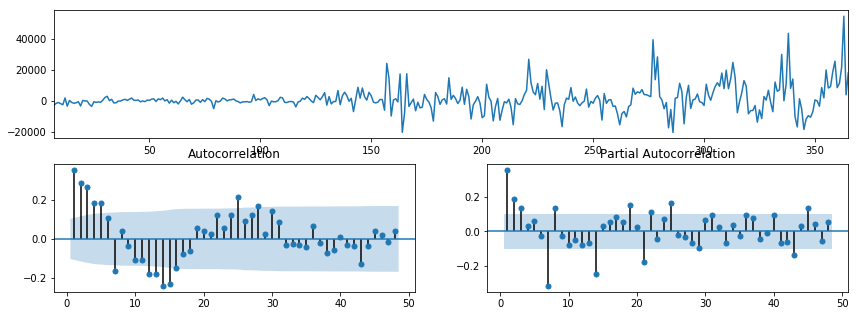

In [28]:
train_day.dropna(inplace=True)# due to shifting there are nan values
train_day.reset_index()
check_stationarity(train_day['ride_day'])

1. The data is stationary now, proceeding futher to build SARIMAX model.
2. The SARIMAX model will be built with and without the exogenous varubles, to undersand their importance
3. After varying the parameters, the following are the values which gave the least RMSE. Hence, building the model with those parameters
(p,d,q)=(2,1,4) and (P,D,Q,s) = (0,1,0,7)


In [29]:
sarima_model_1 = SARIMAX(train_day['ride_day'],order=(2,1,5),seasonal_order=(0,1,0,7),trend='n')
results_sarima_1 = sarima_model_1.fit()

NormaltestResult(statistic=58.24847953352936, pvalue=2.2464842579980778e-13)


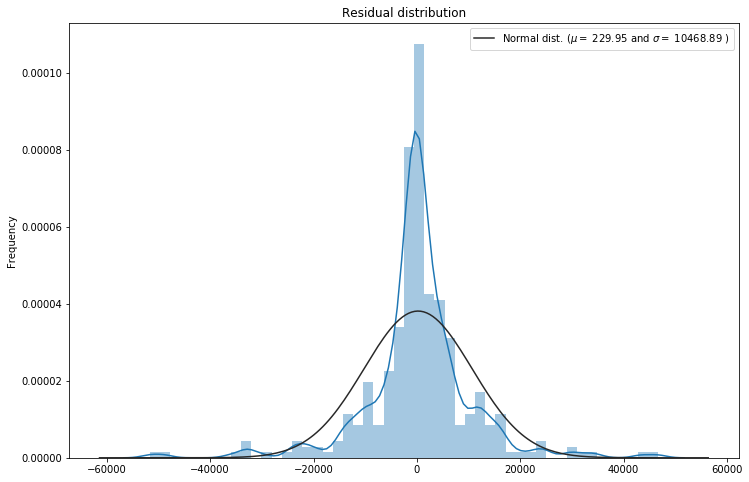

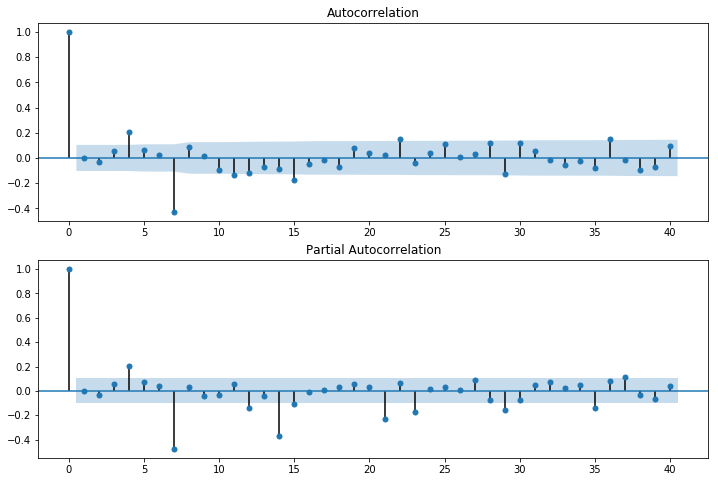

In [30]:
resid = results_sarima_1.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results_sarima_1.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results_sarima_1.resid, lags=40, ax=ax2)

There still seems to be a few peaks but I believe it would do

In [31]:
pred_sarima_1 = pd.DataFrame(results_sarima_1.predict(start=train_day.index[0], end=train_day.index[-1]))


In [32]:
import math
rmse_sma1 = math.sqrt(mean_squared_error(train_day["ride_day"],pred_sarima_1 ))
print(rmse_sma1)

6242.525036492936


In [33]:
## Forecasting into the future
forecast_sma1 = results_sarima_1.get_forecast(steps=40,alpha=0.05)
predictedmean = forecast_sma1.predicted_mean
bounds = forecast_sma1.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]


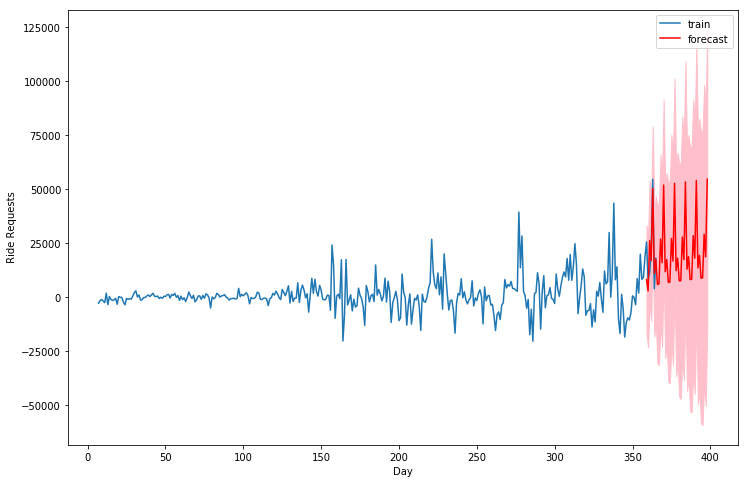

In [34]:
plt.figure(figsize=(12,8))

plt.plot(train_day.index, train_day['ride_day'], label='train')

plt.plot(predictedmean.index, predictedmean, color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')


plt.xlabel('Day')
plt.ylabel(' Ride Requests')
plt.legend()
plt.show()

The model is forcasted for 40days into the future. But seeing how the confindence interval is exponentially widening, in my view the above model is good for forcasting around 25 days into the future

### 3.2.1 SARIMAX with Exogenous variables

In [35]:
train_df_new = pd.merge(train_day, holiday_data, how = 'left', left_on = ['time_stamp'],right_on = ['Date'])


In [36]:
train_df_new = train_df_new.drop(['Day', 'Holiday','Date'], axis=1)


In [37]:
train_df_new.head()

,time_stamp,ride_day,Weightage
0,2018-04-14,-2787.0,NaN
1,2018-04-15,-1523.0,NaN
2,2018-04-16,-1012.0,NaN
3,2018-04-17,-1731.0,NaN
4,2018-04-18,-2483.0,NaN


In [38]:
train_df_new['Weightage'].fillna(0, inplace=True)

In [39]:
train_df_new.head()

,time_stamp,ride_day,Weightage
0,2018-04-14,-2787.0,0.0
1,2018-04-15,-1523.0,0.0
2,2018-04-16,-1012.0,0.0
3,2018-04-17,-1731.0,0.0
4,2018-04-18,-2483.0,0.0


In [40]:
sarima_model_2 = SARIMAX(train_df_new['ride_day'],order=(2,1,4),seasonal_order=(0,1,0,7),trend='n',exog=train_df_new['Weightage'])
results_sarima_2 = sarima_model_2.fit()

In [41]:
results_sarima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          ride_day   No. Observations:                  359
Model:             SARIMAX(2, 1, 4)x(0, 1, 0, 7)   Log Likelihood               -3762.150
Date:                           Tue, 11 Feb 2020   AIC                           7540.300
Time:                                   15:44:05   BIC                           7571.187
Sample:                                        0   HQIC                          7552.593
                                           - 359                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weightage  -1648.0064   1290.048     -1.277      0.201   -4176.454     880.442
ar.L1         -0.6866      0.074     -9.256      0.000      -0.832      -0.541
ar.L2         -0.6061      0.047    -12.799      0.000      -0.699      -0.513
ma.L1         -0.0162      0.131     -0.124      0.902      -0.273       0.240
ma.L2          0.2511      0.114      2.211      0.027       0.029       0.474
ma.L3         -0.7716      0.096     -8.028      0.000      -0.960      -0.583
ma.L4         -0.4629      0.079     -5.877      0.000      -0.617      -0.309
sigma2      1.609e+08    5.9e-05   2.73e+12      0.000    1.61e+08    1.61e+08
===================================================================================
Ljung-Box (Q):                      179.57   Jarque-Bera (JB):               495.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              47.55   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.53e+30. Standard errors may be unstable.
"""

#### The P-value for Weightage is >0.05, that means Weightage parameter is not statistically significant and can be dropped or further evaluated
#### Adding the new column didn't lower the RMSE

In [42]:
pred_sarima_2 = pd.DataFrame(results_sarima_2.predict(start=train_df_new.index[0], end=train_df_new.index[-1]))

rmse_sma2 = math.sqrt(mean_squared_error(train_df_new["ride_day"],pred_sarima_2 ))
print(rmse_sma2)

10382.273848800667


## 4.0 Clustering and Cluster level analysis
Earlier the prediction is done at a day level for all the data given. This may not be particular useful if resource allocation is the key. Further granular level prediction(probably at a range of 5km radius) is required for effective resource allocation

In this section the data is clustered into Zones in the city

Pre-processing 
* Clustering is performed based on the pick up latitude and longitude 
* Upon Clustering Few garbage values which were out of India were found. Below approximate boundaries were appllied to remove those values from the data

Assam   26.2006° N, 92.9376° E

Dwaraka 22.2442° N, 68.9685° E

Jammu:  32.7266° N, 74.8570° E

Kanyakumari: 8.3235° N, 77.3324° E
* To get an idea of the boundaries of banglore, below locations were used as guide

South : Jigani 12.7791° N, 77.6436° E

North : Rjanukunte 13.1747° N, 77.5485° E

East: Hoskote 13.0693° N, 77.7982° E

West: Bidadi 12.7969° N, 77.3838° E

* As of June 2018, Rapido is operational in 12 cities
* As of 24th April 2019 Rapido is operational in 25 cities
* After removing the grabage values, After obtaining 3 clusters I relaised, the data was from all over India
* Hence, I tried to have 25 clusters but it was exceeded the memory allocated by Kaggle. So, I deicided to focus on Banglore, which turns out is 2SD i.e 95% of data.

In [43]:
## Seting limits on the allowable Latitude and Longitude
train_data = train_data.loc[(train_data['pick_lat']>8) & (train_data['pick_lat']<32) ]
train_data = train_data.loc[(train_data['pick_lng']>68) & (train_data['pick_lng']<93) ]

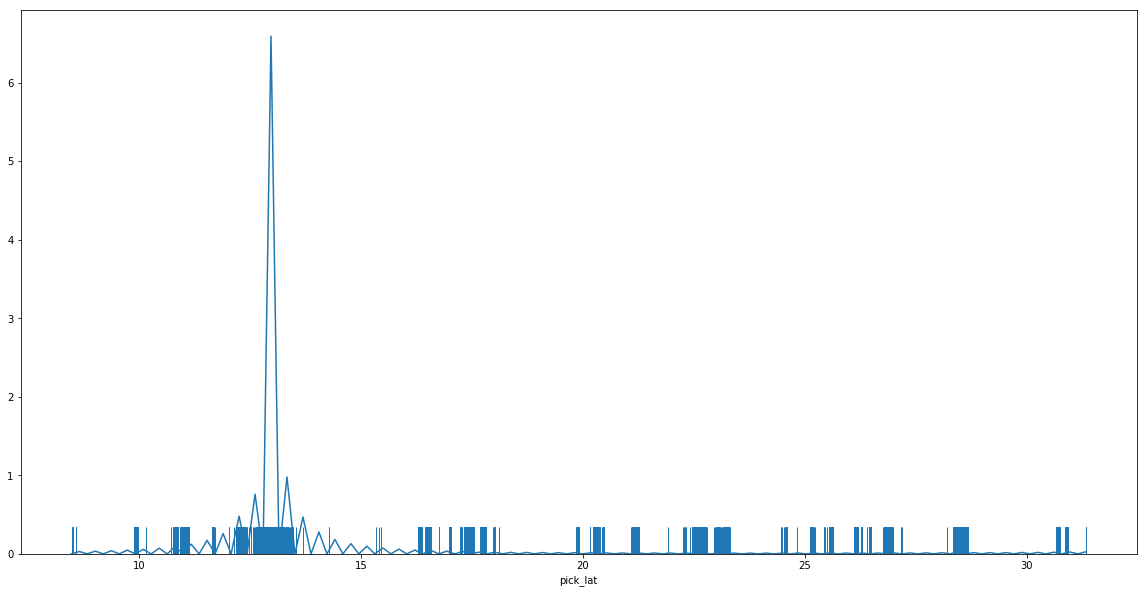

In [44]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['pick_lat'], hist=False, rug=True);

In [45]:
# Filtering out Banglore lat and long
train_data = train_data[(np.abs(stats.zscore(train_data.loc[:, ['pick_lat','pick_lng']])) < 2).all(axis=1)].reset_index()

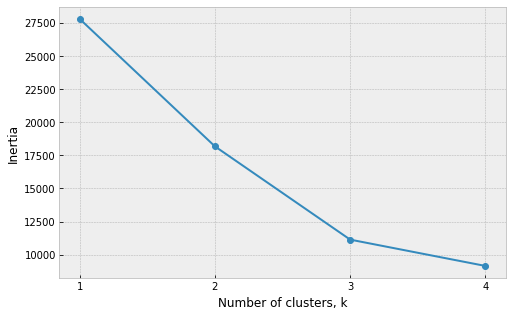

In [46]:
from sklearn.cluster import KMeans
ks = range(1, 5)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k,n_jobs=-1,random_state=123)
    model.fit(train_data.loc[:, ['pick_lat','pick_lng']])
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

From the Scree plot, 3 clusters would suffice. Since I want to divide Banglore into 4 Zones, I will be using 4 clusters

In [47]:
from sklearn.cluster import KMeans
x = train_data.loc[:, ['pick_lat','pick_lng']]
kmeans = KMeans(n_clusters = 4,random_state = 0,n_jobs=-1)
y_kmeans = kmeans.fit_predict(x)

In [48]:
kmeans.cluster_centers_

array([[12.97103079, 77.56044762],
       [12.91492959, 77.61575391],
       [12.95481419, 77.6947486 ],
       [12.98298707, 77.62491636]])

From the centroid Lat and Long, named each cluster as respective Zones in Banglore

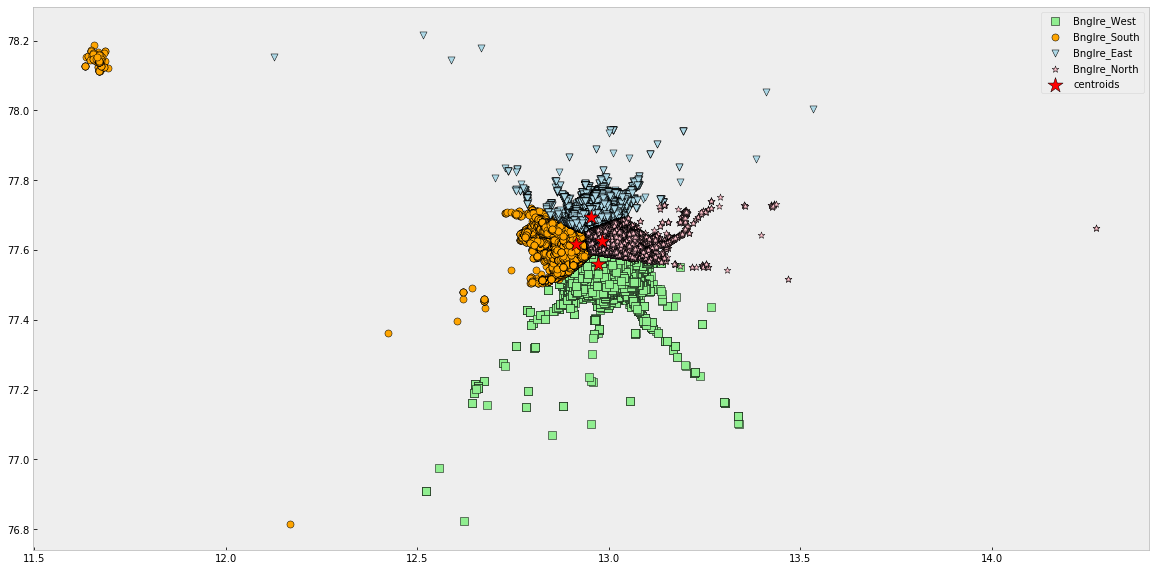

In [49]:
x = x.as_matrix(columns=None)
plt.figure(figsize=(20,10))

plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1],s=50, c='lightgreen',marker='s', edgecolor='black',label='Bnglre_West')

plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1],s=50, c='orange',marker='o', edgecolor='black',label='Bnglre_South')

plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1],s=50, c='lightblue',marker='v', edgecolor='black',label='Bnglre_East')

plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1],s=50, c='pink',marker='*', edgecolor='black',label='Bnglre_North')

# plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],s=250, marker='*',c='red', edgecolor='black',label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.show() 

The Cluster on the Top left is from "Salem" which is close by Banglore

In [50]:
train_data['label'] = kmeans.labels_


In [51]:
train_data.head(2)

,index,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,ride,ride_weekday,ride_hour,label
0,1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.54377,1,Saturday,7,0
1,2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.56995,1,Saturday,7,1


In [52]:
Bnglre_West = train_data[train_data['label']==0]
Bnglre_South = train_data[train_data['label']==1]
Bnglre_East = train_data[train_data['label']==2]
Bnglre_North = train_data[train_data['label']==3]

In [53]:
print(Bnglre_West.shape)
print(Bnglre_South.shape)
print(Bnglre_East.shape)
print(Bnglre_North.shape)
print(train_data.shape)

(1223966, 11)
(3883366, 11)
(1298396, 11)
(1742492, 11)
(8148220, 11)


## 5.0 Model building on Banglore_South Zone
* Most of the ride requests are from Banglore South zone. So, performing analysis on the south zone

**Assumption** : Rides starting in Banglore south, end in Banglore south

In [54]:
Bnglre_South['ride'] = 1
Bnglre_South = pd.DataFrame(Bnglre_South.groupby(pd.Grouper(key='ts', freq='1D')).ride.sum()).to_records()
Bnglre_South = pd.DataFrame(Bnglre_South)
Bnglre_South.columns = ['time_stamp','ride_day']
Bnglre_South.head(2)

,time_stamp,ride_day
0,2018-04-07,4131
1,2018-04-08,2550


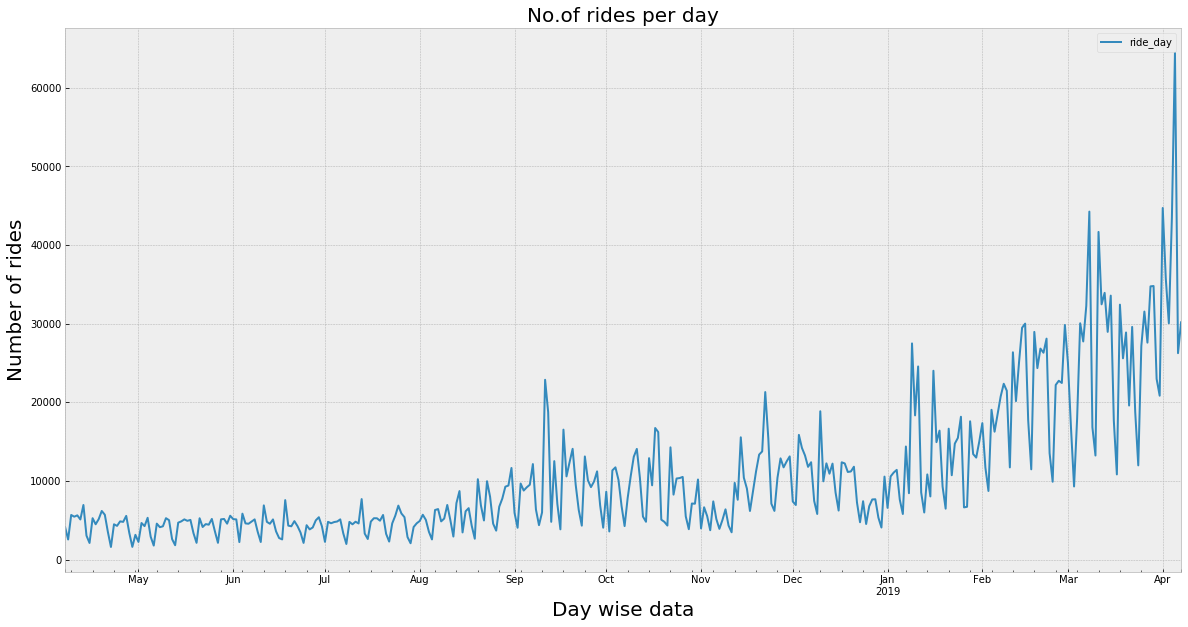

In [55]:
Bnglre_South.plot(x='time_stamp',y='ride_day',figsize=(20,10))
plt.title('No.of rides per day',fontsize=20)
plt.ylabel('Number of rides', fontsize=20)
plt.xlabel('Day wise data', fontsize=20)
plt.show()

Follows similar trend as the complete data

Results of Dickey-Fuller Test:
Test Statistic                   2.1463
p-value                          0.9988
Lags Used                       17.0000
Number of Observations Used    348.0000
Critical Value (1%)             -3.4493
Critical Value (5%)             -2.8699
Critical Value (10%)            -2.5712
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


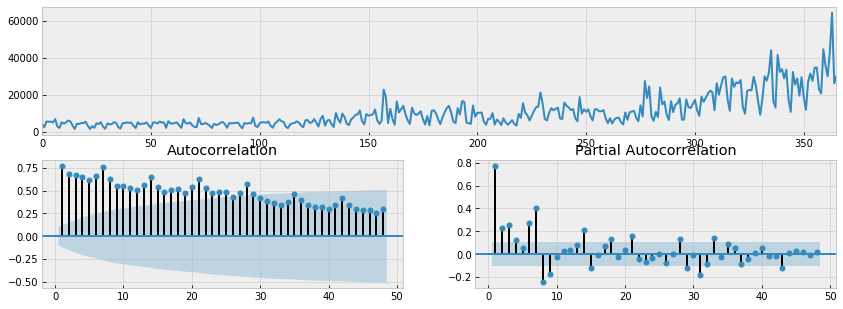

In [56]:
check_stationarity(Bnglre_South['ride_day'])

In [57]:
#Performing a sesonal difference in an attempt to make the data stationary
Bnglre_South['ride_day'] = Bnglre_South['ride_day'] - Bnglre_South['ride_day'].shift(7)


Results of Dickey-Fuller Test:
Test Statistic                  -7.1994
p-value                          0.0000
Lags Used                       13.0000
Number of Observations Used    345.0000
Critical Value (1%)             -3.4494
Critical Value (5%)             -2.8700
Critical Value (10%)            -2.5713
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


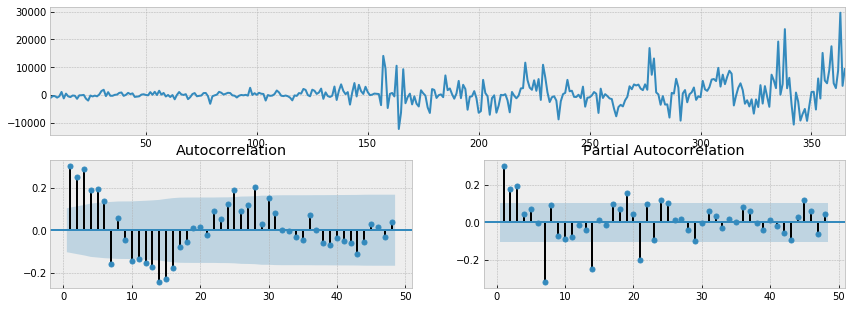

In [58]:
Bnglre_South.dropna(inplace=True)# due to shifting there are nan values
Bnglre_South.reset_index()
check_stationarity(Bnglre_South['ride_day'])

1. The data is stationary now, proceeding futher to build SARIMAX model.
2. The SARIMAX model will be built with and without the exogenous varubles, to undersand their importance
3. After varying the parameters, the following are the values which gave the least RMSE. Hence, building the model with those parameters
(p,d,q)=(3,1,4) and (P,D,Q,s) = (1,1,0,7)


In [59]:
sarima_model_3 = SARIMAX(Bnglre_South['ride_day'],order=(3,1,4),seasonal_order=(1,1,0,7),trend='n')
results_sarima_3 = sarima_model_3.fit()

NormaltestResult(statistic=61.870181872725674, pvalue=3.673336457494175e-14)


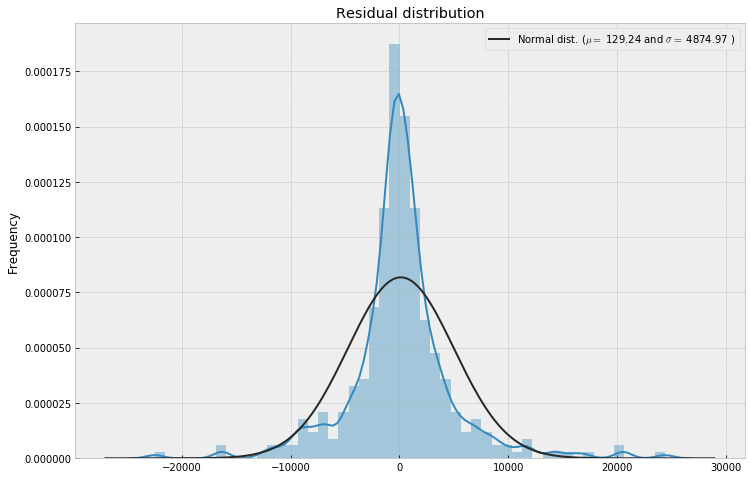

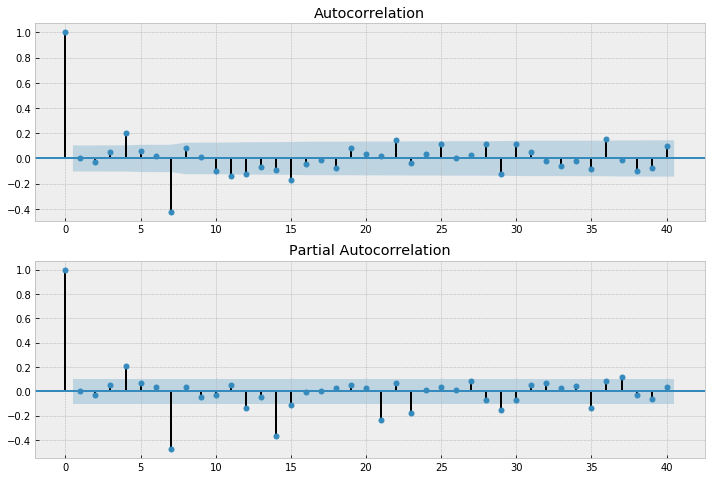

In [60]:
resid = results_sarima_3.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results_sarima_1.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results_sarima_1.resid, lags=40, ax=ax2)

In [61]:
pred_sarima_3 = pd.DataFrame(results_sarima_3.predict(start=Bnglre_South.index[0], end=Bnglre_South.index[-1]))


In [62]:
import math
rmse_sma3 = math.sqrt(mean_squared_error(Bnglre_South["ride_day"],pred_sarima_3 ))
print(rmse_sma3)

4323.225173437426


In [63]:
## Forecasting into the future
forecast_sma3 = results_sarima_3.get_forecast(steps=20,alpha=0.05)
predictedmean = forecast_sma3.predicted_mean
bounds = forecast_sma3.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]

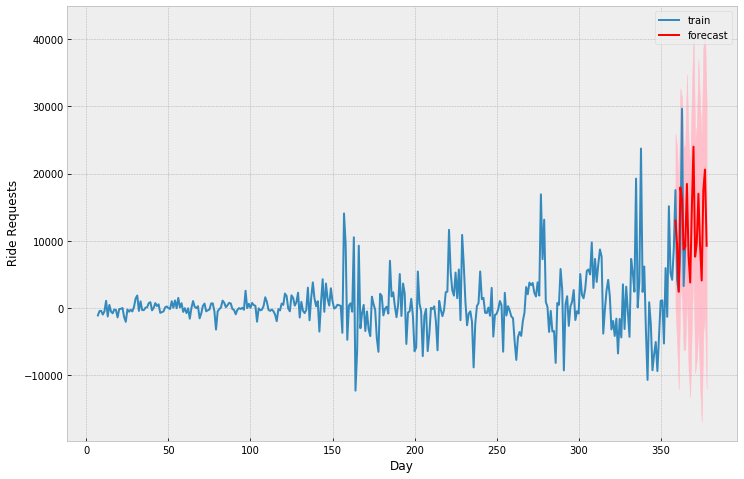

In [64]:
plt.figure(figsize=(12,8))

plt.plot(Bnglre_South.index, Bnglre_South['ride_day'], label='train')

plt.plot(predictedmean.index, predictedmean, color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')


plt.xlabel('Day')
plt.ylabel(' Ride Requests')
plt.legend()
plt.show()

The model is forcasted for 40days into the future. But seeing how the confindence interval is exponentially widening, in my view the above model is good for forcasting around 10 days into the future

## Foot Notes
* I expected the error to increase as we go granualr, but surprisingly it decreased
* Another aspect to note is that the confidence intervals widened at cluster level forecast, hence decreasing the forecast window
* Banglore_south can further be clustered into 3-4 clusters for more granualr prediciton
* Analysis similar to Banglore_south can be done for other Zones as well